# Construction of Route Graphs

In [1]:
import json
import time
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import isodate

### Load Json

In [2]:
scenario = "sample_scenario.json"  # adjust path to the sample instance if it is not located there
with open(scenario) as fp:
    scenario = json.load(fp)

### Process section requirements

In [3]:
service_intentions = {}
for si in scenario['service_intentions']:
    requirements = {}
    for i,req in enumerate(si['section_requirements']):
        requirements[req['section_marker']] = {key:value for key,value in req.items()}
        if i == 0:
            requirements[req['section_marker']]['start_end'] = 'start'
        elif i == len(si['section_requirements']) - 1:
            requirements[req['section_marker']]['start_end'] = 'end'
        else: 
            requirements[req['section_marker']]['start_end'] = None
    service_intentions[si['id']] = requirements

### Printing of nodes

In [4]:
def from_node_id(route_path, route_section, index_in_path):
    if "route_alternative_marker_at_entry" in route_section.keys() and \
            route_section["route_alternative_marker_at_entry"] is not None and \
            len(route_section["route_alternative_marker_at_entry"]) > 0:
                return "(" + str(route_section["route_alternative_marker_at_entry"][0]) + ")"
    else:
        if index_in_path == 0:  # can only get here if this node is a very beginning of a route
            return "(" + str(route_section["sequence_number"]) + "_beginning)"
        else:
            return "(" + (str(route_path["route_sections"][index_in_path - 1]["sequence_number"]) + "->" +
                          str(route_section["sequence_number"])) + ")"
def to_node_id(route_path, route_section, index_in_path):
    if "route_alternative_marker_at_exit" in route_section.keys() and \
            route_section["route_alternative_marker_at_exit"] is not None and \
            len(route_section["route_alternative_marker_at_exit"]) > 0:

                return "(" + str(route_section["route_alternative_marker_at_exit"][0]) + ")"
    else:
        if index_in_path == (len(route_path["route_sections"]) - 1): # meaning this node is a very end of a route
            return "(" + str(route_section["sequence_number"]) + "_end" + ")"
        else:
            return "(" + (str(route_section["sequence_number"]) + "->" +
                          str(route_path["route_sections"][index_in_path + 1]["sequence_number"])) + ")"

### Construct graph for every SI, and appropriate edge constraints

In [5]:
route_section_keys = ['penalty', 'minimum_running_time']
section_requirement_keys = ['start_end','min_stopping_time', 'entry_earliest', 'entry_latest',
                           'exit_earliest', 'exit_latest', 'entry_delay_weight',
                           'exit_delay_weight']

In [6]:
start_time = time.time()

# now build the graph. Nodes are called "previous_FAB -> next_FAB" within lineare abschnittsfolgen and "AK" if
# there is an Abschnittskennzeichen 'AK' on it
route_graphs = dict()
for route in scenario["routes"]:# iterates over si?
    
    print(f"\nConstructing route graph for route {route['id']}")
    # set global graph settings
    G = nx.DiGraph(route_id = route["id"], name="Route-Graph for route "+str(route["id"]))

    # add edges with data contained in the preprocessed graph
    for path in route["route_paths"]:#iterate over admissible routes
        print('new route')
        for (i, route_section) in enumerate(path["route_sections"]):
            sn = route_section['sequence_number']
            print("Adding Edge from {} to {} with sequence number {}".format(from_node_id(path, route_section, i), to_node_id(path, route_section, i), sn))
            edge_data = {}
            for key in route_section_keys:
                if key in route_section:
                    edge_data[key] = route_section[key]
                else:
                    edge_data[key] = None
            #get section marker
            section_marker = None
            if 'section_marker' in route_section:
                section_marker = route_section['section_marker'][0]
            edge_data['section_marker'] = section_marker
            
            if section_marker in service_intentions[route['id']]:
                for key in section_requirement_keys:
                    if key in service_intentions[route['id']][section_marker]:
                            edge_data[key] = service_intentions[route['id']][section_marker][key]
        
            edge_data['sequence_number'] = sn
            
            print(edge_data)
            G.add_edge(from_node_id(path, route_section, i),
                       to_node_id(path, route_section, i),
                       edge_data = edge_data)

    route_graphs[route["id"]] = G

print("Finished building fahrweg-graphen in {} seconds".format(str(time.time() - start_time)))


Constructing route graph for route 111
new route
Adding Edge from (1_beginning) to (M1) with sequence number 1
{'penalty': None, 'minimum_running_time': 'PT53S', 'section_marker': 'A', 'start_end': 'start', 'entry_earliest': '08:20:00', 'entry_delay_weight': 1, 'exit_delay_weight': 1, 'sequence_number': 1}
Adding Edge from (M1) to (4->5) with sequence number 4
{'penalty': None, 'minimum_running_time': 'PT32S', 'section_marker': None, 'sequence_number': 4}
Adding Edge from (4->5) to (M2) with sequence number 5
{'penalty': None, 'minimum_running_time': 'PT32S', 'section_marker': 'B', 'start_end': None, 'min_stopping_time': 'PT3M', 'exit_earliest': '08:30:00', 'entry_delay_weight': 1, 'exit_delay_weight': 1, 'sequence_number': 5}
Adding Edge from (M2) to (M3) with sequence number 6
{'penalty': None, 'minimum_running_time': 'PT32S', 'section_marker': None, 'sequence_number': 6}
Adding Edge from (M3) to (10->13) with sequence number 10
{'penalty': None, 'minimum_running_time': 'PT32S', 'se

### Draw Graphs

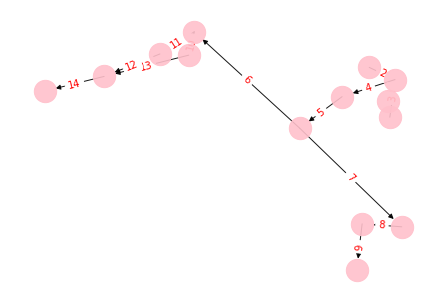

In [7]:
route_graph = route_graphs[111]

"""
for node in route_graph.nodes():
    route_graph.node[node]['label'] = node

edge_labels = {}
for node1, node2, data in route_graph.edges(data=True):
    edge_labels[(node1, node2)] = data['sequence_number'] 

for edge in route_graph.edges():
    route_graph.edges[edge]['label'] = edge_labels[edge]

# export as graphML file, see below
nx.write_graphml(route_graph, "graph-111"+".graphml")
"""
edge_labels = {}
for node1, node2, data in route_graph.edges(data=True):
    
    edge_labels[(node1, node2)] = data['edge_data']['sequence_number']
    
# draw directly from networkx
pos = nx.spring_layout(route_graph)
nx.draw(route_graph, pos, edge_color='black', width=1, linewidths=1, node_size=500, node_color='pink', alpha=0.9)
nx.draw_networkx_edge_labels(route_graph,pos,edge_labels=edge_labels,font_color='red')
plt.show()

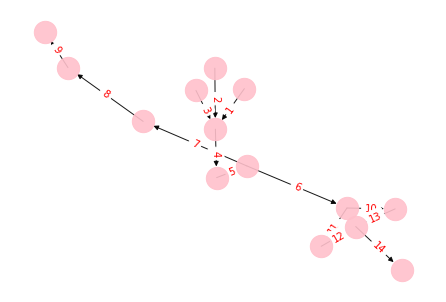

In [8]:
route_graph = route_graphs[113]

"""
for node in route_graph.nodes():
    route_graph.node[node]['label'] = node

edge_labels = {}
for node1, node2, data in route_graph.edges(data=True):
    edge_labels[(node1, node2)] = data['sequence_number'] 

for edge in route_graph.edges():
    route_graph.edges[edge]['label'] = edge_labels[edge]

# export as graphML file, see below
nx.write_graphml(route_graph, "graph-111"+".graphml")
"""
edge_labels = {}
for node1, node2, data in route_graph.edges(data=True):
    edge_labels[(node1, node2)] = data['edge_data']['sequence_number']

# draw directly from networkx
pos = nx.spring_layout(route_graph)
nx.draw(route_graph, pos, edge_color='black', width=1, linewidths=1, node_size=500, node_color='pink', alpha=0.9)
nx.draw_networkx_edge_labels(route_graph,pos,edge_labels=edge_labels,font_color='red')
plt.show()

### Find all admissible routes

In [9]:
paths = {}
for si in service_intentions:
    startnodes=[]
    endnodes = []
    G = route_graphs[si]
    for edge in G.edges(data=True):
        if 'start_end' in edge[2]['edge_data']:
            if edge[2]['edge_data']['start_end'] == 'start':
                startnodes.append(edge[0])
            if edge[2]['edge_data']['start_end'] == 'end':
                endnodes.append(edge[1])
    paths_si = []
    for s in startnodes:
        for e in endnodes:
            for path in nx.all_simple_paths(G, source=s, target=e):
                paths_si.append([(path[i], path[i+1]) for i in range(len(path)-1)])
    paths[si] = paths_si

In [10]:
si_list = []
for si in paths:
    pathlist = []
    for i,path in enumerate(paths[si]):
        srlist = []
        for sr in path:
            srlist.append((si,i,sr))
        pathlist.append(srlist)
    si_list.append(pathlist)

In [11]:
si_list

[[[(111, 0, ('(1_beginning)', '(M1)')),
   (111, 0, ('(M1)', '(4->5)')),
   (111, 0, ('(4->5)', '(M2)')),
   (111, 0, ('(M2)', '(M3)')),
   (111, 0, ('(M3)', '(10->13)')),
   (111, 0, ('(10->13)', '(M4)')),
   (111, 0, ('(M4)', '(14_end)'))],
  [(111, 1, ('(1_beginning)', '(M1)')),
   (111, 1, ('(M1)', '(4->5)')),
   (111, 1, ('(4->5)', '(M2)')),
   (111, 1, ('(M2)', '(M3)')),
   (111, 1, ('(M3)', '(11->12)')),
   (111, 1, ('(11->12)', '(M4)')),
   (111, 1, ('(M4)', '(14_end)'))],
  [(111, 2, ('(1_beginning)', '(M1)')),
   (111, 2, ('(M1)', '(4->5)')),
   (111, 2, ('(4->5)', '(M2)')),
   (111, 2, ('(M2)', '(7->8)')),
   (111, 2, ('(7->8)', '(8->9)')),
   (111, 2, ('(8->9)', '(9_end)'))],
  [(111, 3, ('(2_beginning)', '(M1)')),
   (111, 3, ('(M1)', '(4->5)')),
   (111, 3, ('(4->5)', '(M2)')),
   (111, 3, ('(M2)', '(M3)')),
   (111, 3, ('(M3)', '(10->13)')),
   (111, 3, ('(10->13)', '(M4)')),
   (111, 3, ('(M4)', '(14_end)'))],
  [(111, 4, ('(2_beginning)', '(M1)')),
   (111, 4, ('(M1)',

In [12]:
def recursive_len(item):
    if type(item) == list:
        return sum(recursive_len(subitem) for subitem in item)
    else:
        return 1

In [13]:
t_len = recursive_len(si_list)
x_len = 0
delta_len = 0
for si in service_intentions:
    x_len += len(route_graphs[si].edges)
    delta_len += len(paths[si])
total_length = t_len*2 + x_len + delta_len
total_length

286

### Variables

|t_in| = sum of the length of all service intentions, total number of paths per si and route sections per path  
|t_out| same as t_in  

|x| all service intentions and their route sections

|delta| all service intentions and their paths

$v = [t_{in}, t_{out} , x, \delta]$

#### Minimize objective function

$J(x)=\{ \frac{1}{60} \sum_{SI, R, RS} win_{rs}max(0, 
t_{si,r,rs}^{in} - LatIn_{si,rs}) + wout_{rs} max(0, t_{si,r,rs}^{out} - LatOut_{si,rs}) + p_{si,rs}x_{si,rs} \}$  



#### Subject to

time into a section comes before time out: 


(1)  $t_{si,r,rs}^{in} \leq t_{si,r,rs}^{out}$  

time into next section comes after time out from previous section:  
(2)  $t_{si,r,rs}^{out} \leq t_{si,r,rs+1}^{in}$

if r is the selected path, satisfy minimum running and stopping time:  
(3)  $t_{si,r,rs}^{out} - t_{si,r,rs}^{in} \geq mrt_{si, r, rs} + mst_{si, r, rs} - M(1-\delta_{si,r})$

Earliest in constraint:  
(4)  $t_{si,r,rs}^{in} \geq EarIn_{si,r,rs} - M(1-\delta_{si,r})$  

Earliest out constraint:  
(5)  $t_{si,r,rs}^{out} \geq EarOut_{si,r,rs} - M(1-\delta_{si,r})$

Select only one path to every service:  
(6)  $\sum_{r \in P} \delta_{si,r} = 1$




In [14]:
def str_to_sec(s):
    s=s.split(':')
    return int(s[0])*60*60+int(s[1])*60+int(s[2])

### Matrix approach

In [15]:

A = np.array([])
b = []

#load (1)
i = 0
for si in si_list:
    for r in si:
        for rs in r:
            temp = np.zeros(total_length)
            temp[i] = 1 #tin
            temp[i+t_len] = -1 #tout
            b.append(0)
            i+=1
            if len(A)==0:
                A = temp
            else:
                A = np.vstack((A,temp))
#load (2)
i = 0
for si in si_list:
    for r in si:
        for j, rs in enumerate(r):
            if j!=len(r)-1:
                temp = np.zeros(total_length)
                temp[i+1] = -1 #tin
                temp[i+t_len] = 1 #tout
                b.append(0)

                if len(A)==0:
                    A = temp
                else:
                    A = np.vstack((A,temp))
            i+=1

#load (3)
i = 0
j = 0
M = 1000000
for si, si_id in zip(si_list, service_intentions):
    for r in si:
        for rs in r:
                edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
            
                if ('min_stopping_time' in edge_data) or ('minimum_running_time' in edge_data):
                    mst = 0
                    mrt = 0
                    if 'min_stopping_time' in edge_data:
                        mst = isodate.parse_duration(edge_data['min_stopping_time']).seconds
                    if 'minimum_running_time' in edge_data:
                        mrt = isodate.parse_duration(edge_data['minimum_running_time']).seconds
                
                    temp = np.zeros(total_length)
                    temp[i] = 1 #tin
                    temp[i+t_len+1] = -1 #tout
                    temp[j+t_len+t_len+x_len] = M
                    b.append(M-mst-mrt)
                    
                    if len(A)==0:
                        A = temp
                    else:
                        A = np.vstack((A,temp))
                i+=1
        j+=1
        
print(j)        
#load (4)
i = 0
j = 0
M = 1000000
for si, si_id in zip(si_list, service_intentions):
    for r in si:
        for rs in r:
                edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
            
                if ('entry_earliest' in edge_data):
                    EarIn = str_to_sec(edge_data['entry_earliest'])
                        
                    temp = np.zeros(total_length)
                    temp[i] = -1 #tin
                    temp[j+t_len+t_len+x_len] = M
                    b.append(M-EarIn)
                    if len(A)==0:
                        A = temp
                    else:
                        A = np.vstack((A,temp))
                i+=1
        j+=1
        

#load (5)
i = 0
j = 0
M = 1000000
for si, si_id in zip(si_list, service_intentions):
    for r in si:
        for rs in r:
                edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
            
                if ('exit_earliest' in edge_data):
                    EarOut = str_to_sec(edge_data['exit_earliest'])
                        
                    temp = np.zeros(total_length)
                    temp[i + t_len] = -1 #tin
                    temp[j+t_len+t_len+x_len] = M
                    b.append(M-EarOut)
                    if len(A)==0:
                        A = temp
                    else:
                        A = np.vstack((A,temp))
                i+=1
        j+=1
b = np.array(b).astype('float64')
c = np.array([1.0]*total_length)

18


### Modelling approach

In [16]:
from cvxopt.modeling import variable, op, max, sum, matrix

In [27]:

tin = [variable(1)]*t_len
tout = [variable(1)]*t_len
#xs = [variable(1)]*x_len
deltas = [variable(1)]*delta_len
cs = []

#load (1)
i = 0
for si in si_list:
    for r in si:
        for rs in r:
            tcon = (tin[i]-tout[i] <= 0)
            cs.append(tcon)
            i+=1
#load (2)
i = 0
for si in si_list:
    for r in si:
        for j, rs in enumerate(r):
            if j!=len(r)-1:
                tcon = (-tin[i+1]+tout[i] <= 0)
                cs.append(tcon)
            i+=1

#load (3)
i = 0
j = 0
M = 1000000
for si, si_id in zip(si_list, service_intentions):
    for r in si:
        for rs in r:
                edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
            
                if ('min_stopping_time' in edge_data) or ('minimum_running_time' in edge_data):
                    mst = 0
                    mrt = 0
                    if 'min_stopping_time' in edge_data:
                        mst = isodate.parse_duration(edge_data['min_stopping_time']).seconds
                    if 'minimum_running_time' in edge_data:
                        mrt = isodate.parse_duration(edge_data['minimum_running_time']).seconds
                
                    
                    tcon = (tin[i] - tout[i] + M*deltas[j] <= M-mst-mrt)
                    cs.append(tcon)
                    
                i+=1
        j+=1
           
#load (4)
i = 0
j = 0
M = 1000000
for si, si_id in zip(si_list, service_intentions):
    for r in si:
        for rs in r:
                edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
            
                if ('entry_earliest' in edge_data):
                    EarIn = str_to_sec(edge_data['entry_earliest'])
                    tcon = (-tin[i] + M*deltas[j] <= M-EarIn)
                    cs.append(tcon)
                    
                i+=1
        j+=1
        

#load (5)
i = 0
j = 0
M = 1000000
for si, si_id in zip(si_list, service_intentions):
    for r in si:
        for rs in r:
                edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
            
                if ('exit_earliest' in edge_data):
                    EarOut = str_to_sec(edge_data['exit_earliest'])
                        
                    tcon = (-tout[i] + M*deltas[j] <= M-EarOut)
                    cs.append(tcon)
                        
                i+=1
        j+=1


#load (6)
j = 0
for si, si_id in zip(si_list, service_intentions):
    tempsum = 0
    for r in si:
        tempsum += deltas[j]
        j +=1
    tcon = (tempsum == 1.0)
    cs.append(tcon)
    
            

In [28]:
objective = 0
i = 0
for si, si_id in zip(si_list, service_intentions):
    for r in si:
        for rs in r:
            edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
            if 'entry_delay_weight' in edge_data and 'entry_latest' in edge_data:
                objective += float(edge_data['entry_delay_weight'])*max(0, tin[i]-str_to_sec(edge_data['entry_latest']))
            if 'exit_delay_weight' in edge_data and 'exit_latest' in edge_data:
                objective += float(edge_data['exit_delay_weight'])*max(0, tout[i]-str_to_sec(edge_data['exit_latest']))
            i+=1
i = 0
for si, si_id in zip(si_list, service_intentions):
    for edge in route_graphs[si_id].edges(data=True):
        p = 0
        if 'penalty' in edge[2]['edge_data']:
            p = edge[2]['edge_data']['penalty']
            if p == None:
                p = 0
            else:
                p = float(p)
            #objective += xs[i]*p
        i+=1

In [29]:
lp = op(objective, cs)
lp.solve()

ValueError: Rank(A) < p or Rank([G; A]) < n

In [20]:
from cvxopt.modeling import variable, op, max, sum, matrix

In [23]:
A = [[2.,1.,-1.,0.], [1.,2.,0.,-1.]]
b = [3.,3.,0.,0.]
c = [-4.,-5.]

In [24]:
x = variable(2)
A = matrix(A)
b = matrix(b)
c = matrix(c)
ineq = ( A*x <= b )
obj = dot(c,x)
lp2 = op(obj, ineq)
lp2.solve()

NameError: name 'dot' is not defined

In [25]:
from cvxopt.modeling import op
xs = []
for i in range(2):
    temp = variable()
    xs.append(temp)
c1 = ( 0.3*xs[0]+0.1*xs[1] <= 2.7 )
c2 = ( xs[0]+2*xs[1] <= 3 )
c3 = ( xs[0] >= 2 )
c4 = ( xs[1] >= 0 )
lp1 = op(-4*xs[0]-5*xs[1], [c1,c2,c3,c4])
lp1.solve()
lp1.status
print(xs[0].value)

     pcost       dcost       gap    pres   dres   k/t
 0: -1.1350e+01 -2.0812e+01  7e+00  0e+00  5e-01  1e+00
 1: -1.1943e+01 -1.4696e+01  2e+00  2e-16  1e-01  3e-01
 2: -1.1999e+01 -1.2027e+01  2e-02  2e-16  1e-03  3e-03
 3: -1.2000e+01 -1.2000e+01  2e-04  1e-16  1e-05  3e-05
 4: -1.2000e+01 -1.2000e+01  2e-06  1e-16  1e-07  3e-07
 5: -1.2000e+01 -1.2000e+01  2e-08  1e-16  1e-09  3e-09
Optimal solution found.
[ 3.00e+00]



In [26]:
edge_data

{'penalty': None,
 'minimum_running_time': 'PT32S',
 'section_marker': 'C',
 'start_end': 'end',
 'exit_latest': '08:16:00',
 'entry_delay_weight': 1,
 'exit_delay_weight': 1,
 'sequence_number': 9}

In [228]:
route_graphs[111].edges.data

<bound method OutEdgeView.data of OutEdgeView([('(1_beginning)', '(M1)'), ('(M1)', '(4->5)'), ('(4->5)', '(M2)'), ('(M2)', '(M3)'), ('(M2)', '(7->8)'), ('(M3)', '(10->13)'), ('(M3)', '(11->12)'), ('(10->13)', '(M4)'), ('(M4)', '(14_end)'), ('(2_beginning)', '(M1)'), ('(3_beginning)', '(M1)'), ('(7->8)', '(8->9)'), ('(8->9)', '(9_end)'), ('(11->12)', '(M4)')])>